## Project 3 - Polynomial Interpolation

## Introduction

### Project Structure

In [1]:
%ls ..

MATH3316-Project3.xcodeproj/ lib/
bin/                         res/
doc/                         src/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions.
- `bin/`: compiled binaries. Make will put binaries here by default.
- `doc/`: directory containing all documentation, including this report.
- `lib/`: reused libraries that are not part of this project specifically. Contains a rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `res/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows. For this project, the `.txt` files are also organized into separate `res/part{1..3}/` directories.
- `src/`: contains the C++ implementations of the calculations described in this report.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
    - matplotlib
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks with new data files, and convert them to PDFs in `res/reports/`.

`make all_bin` - will compile binaries for part 1 and 2 of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and report PDFs.

## Part 1 - Newton Form

In this section, we focus on interpolation using the Newton form in addition to the resulting error analysis relative to the function as calculated using the built-in function.

### Background

#### Newton form for interpolation

##### Method for determining coefficients
The Newton form interpolates $k + 1$ data points $(x_0, y_0),\ (x_1, y_1),\ ...\ ,\ (x_k, y_k)$ using a polynomial of degree $k$:

$$
p_{k}(x) = a_0 + a_1(x - x_0) + a_2(x - x_0)(x - x_1) +\ ...\ + a_k(x - x_0)(x - x_1)\ ...\ (x - x_{k-1})
$$

where $a_0,\ a_1,\ ...\ ,\ a_k$ is a set of unknown coefficients. We can determine these coefficients using the $k + 1$ interpolating conditions $p_k(x_0) = y_0,\ p_k(x_1) = y_1,\ ...\ ,\ p_k(x_k) = y_k$.

If one more data point $(x_{k+1}, y_{k+1})$ is added, then the new interpolating polynomial of degree $k + 1$ can be written as

$$
p_{k+1}(x) = p_k(x) + a_{k+1}(x - x_0)(x - x_1)\ ...\ (x - x_k)
$$

The new coefficient $a_{k+1}$ can be determined using the new interpolating condition $p_{k+1}(x_{k+1}) = y_{k+1}$ with the formula

$$
a_{k+1} = \frac{y_{k+1} - p_k(x_{k+1})}{(x_{k+1} - x_0)(x_{k+1} - x_1)\ ...\ (x_{k+1} - x_k)}
$$

This formula can then be used to find the coefficients $a_1,\ a_2,\ ...\ ,\ a_k$ by starting with the initial polynomial $p_0(x) = a_0 = y_0$ and $k = 0,\ 1,\ ...,\ k$.

For example, when $k = 0$ and $p_0(x) = a_0 = y_0$,

$$
a_1 = \frac{y_1 - p_0(x_1)}{x_1 - x_0}
$$

This, in turn, can be used to find the interpolating polynomial through the two data points $(x_0, y_0)$ and $(x_1, y_1)$

$$
p_1(x) = a_0 + a_1(x - x_0)
$$

Continuing this process will yield all coefficients $a_0,\ a_1,\ ...\ ,\ a_k$. 

##### Evaluating $p_k(x)$

When calculating $a_{k+1}$, it is necessary to evaluate $p_k(x)$. Nested multiplication works well for this.

$$
p_k(x) = a_0 + a_1(x - x_0) + a_2(x - x_0)(x - x_1) +\ ...\ + a_k(x - x_0)(x - x_1)\ ...\ (x - x_{k-1}) \\
       = a_0 + (x - x_0) * (a_1 + (x - x_1) * (a_2 +\ ...\ + (x - x_{k-2}) * (a_{k-1} + a_k * (x - x_{k-1})))
$$

##### Newton's basis function

In addition to evaluating $p_k(x)$, we also need to calculate the product $(x_{k+1} - x_0)(x_{k+1} - x_1)\ ...\ (x_{k+1} - x_k)$. Essentially, this is evaluating Newton's basis function

$$
\phi_{k+1}(x) = \prod_{n\ =\ 0}^{k} (x - x_k) = (x - x_0)(x - x_1)\ ...\ (x - x_k)\ ,\ x = x_{k+1}
$$

### Implementation

#### Newton form

Newton's form as described above is implemented with the functions `Newton_basis`, `Newton_nestedform`, and `Newton_coefficients`.

`Newton_basis` evaluates Newton's basis function $\phi_{k+1}(x)$ using a given `PH::Vector` of $x$-nodes, a given value $k$ representing the extent to which $\phi_{k+1}(x)$ is evaluated, and a given value $x$ to evaluate.

`Newton_nestedform` performs nested multiplication using a given `PH::Vector` of coefficients, a `PH::Vector` of $x$-nodes, and a given value $x$ to evaluate.

`Newton_coefficients` returns a `PH::Vector` of coefficients $a_0,\ a_1,\ ...\ ,\ a_k$ using `PH::Vector`s of $x$-nodes and $y$-nodes. This function uses both `Newton_basis` and `Newton_nestedform` in its calculations.

These functions are organized into a class `NewtonInterpolator` contained in the files `newton_interpolator.cpp` and `newton_interpolator.hpp`.

#### Testing

This implementation of Newton's form is tested using data generated from the function

$$
f(x) = 3.1x^4 + 2.3x^3 - 6.6x^2 + 8.7x + 7.9\ ,\ x \in \{-2, -1, 0, 1, 2\}
$$

Using a `PH::Vector` containing $\{-2, -1, 0, 1, 2\}$, and the generated $y$-values, the coefficients $a_0,\ a_1,\ ...\ ,\ a_k$ are generated using `Newton_coefficients`.

Then, using a series of `PH::Vector`s to store the data, the original function $f(x)$, the interpolating polynomial $p_4(x)$, and the error $|f(x) - p_4(x)|$ are computed using a series of 201 equally spaced values over the interval $[-3,3]$.


### Analysis



In [91]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [92]:
names = [ 'y_real', 'y_comp', 'y_err', ]
data = {name: loadtxt('../res/part1/'+name+'.txt') for name in names}
data['x'] = linspace(-3,3,201) 

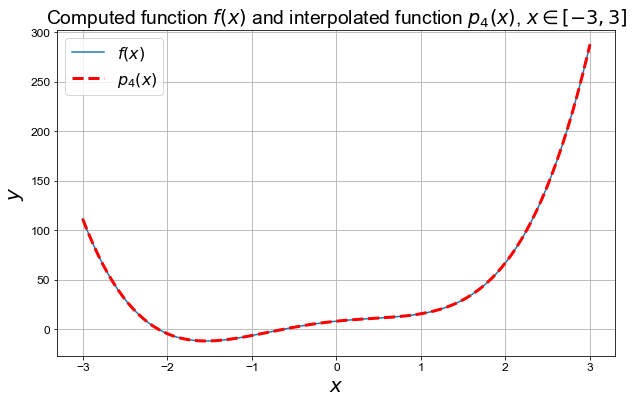

In [93]:
# plot in one figure your interpolating polynomial p_4(x) along with the function f(x)

pylab.plot(data['x'], data['y_real'], linestyle='-')
pylab.plot(data['x'], data['y_comp'], linestyle='--', color='r', linewidth=3)

pylab.title('Computed function $f(x)$ and interpolated function $p_4(x)$, $x \in [-3, 3]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$f(x)$',
              '$p_4(x)$'))

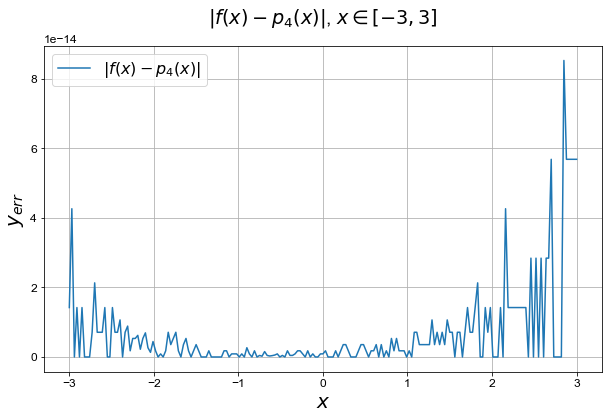

In [94]:
# in another figure, plot the error f(x) − p_4(x) using the same 201 points

pylab.plot(data['x'], data['y_err'])

pylab.title('$|f(x) - p_{4}(x)|$, $x \in [-3, 3]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_4(x)|$',))

There exists only one polynomial that can pass through a given set of discrete data points for a polynomial of degree $n$. Both the original function $f(x)$ and the interpolating polynomial $p_4(x)$ are of degree 4. Given these facts, both the original function and the interpolating polynomial should, in theory, match each other. Given the output as shown by the graph and the infinitesimal scale of the error, this claim seems to be true.

The error $|f(x) - p_4(x)|$ was essentially insignificant and seems to occur mostly from computational error. However, it does seem to increase at either end of the interval $[-3,3]$. It's possible that this relates to computing larger floating point numbers at either end of the interval.

## Part 2 - Effects of Degrees and Nodes

This section explores the effects of varying initial data points when using interpolation, in this case using the Lagrange method for interpolation.

### Background

#### Lagrange method for interpolation

For a set of data points
$$
(x_i,y_i) = (x_0,y_0), (x_1,y_1), ..., (x_n,y_n)\ ,\ i = 0, 1,\ ...,\ n
$$

the Lagrange interpolating polynomial takes the form

$$
p_n(x) = y_0L_0(x)\ +\ y_1L_1(x)\ +\ ...\ +\ y_nL_i(x)\ ,\ i = 0, 1,\ ...,\ n
$$

where $L_i(x)$ takes the form

$$
L_i(x) = \frac{ (x - x_0)\ ...\ (x - x_{i-1})(x - x_{i+1})\ ...\ (x - x_n) }{ (x_i - x_0)\ ...\ (x_i - x_{i-1})(x_i - x_{i+1})\ ...\ (x_i - x_n) } \\
       = \prod_{j\ =\ 0,\ j\ \neq\ i}^{n} (\frac{x - x_j}{x_i - x_j})\ i = 0, 1,\ ...,\ n
$$

### Implementation

The C++ functions necessary to construct a Lagrangian interpolating polynomial were included along with the project requirements as written by Dr. Daniel Reynolds. However, we have modified this code in order to work with the `PH::Vector` class.

The `lagrange_basis` function computes the Langrange basis $L_i(x)$ using a given `PH::Vector` of $x$-values, a given value $i$, and a given value $z$. In the sigma notation from the previous section, this function performs the equivalent of

$$
L_i(x) = \prod_{j\ =\ 0,\ j\ \neq\ i}^{n} (\frac{z - x_j}{x_i - x_j})\ i = 0, 1,\ ...,\ n
$$

The `lagrange` function evaluates the Lagrange interpolating polynomial

$$
p_n(x) = y_0L_0(x)\ +\ y_1L_1(x)\ +\ ...\ +\ y_nL_i(x)\ ,\ i = 0, 1,\ ...,\ n
$$

defined over a set of data points

$$
(x_i,y_i) = (x_0,y_0), (x_1,y_1), ..., (x_n,y_n)\ ,\ i = 0, 1,\ ...,\ n
$$

at a point $z$ using a `PH::Vector x` containing the $x$-nodes, a `PH::Vector y` containing the $y$-nodes, and the $z$ value.

### Analysis

#### Part A

In [109]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [110]:
names = [ 'y_real10', 'y_comp10', 'y_err10', 'y_real20', 'y_comp20', 'y_err20', 'omega10', 'omega20' ]
data = {name: loadtxt('../res/part2/function/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

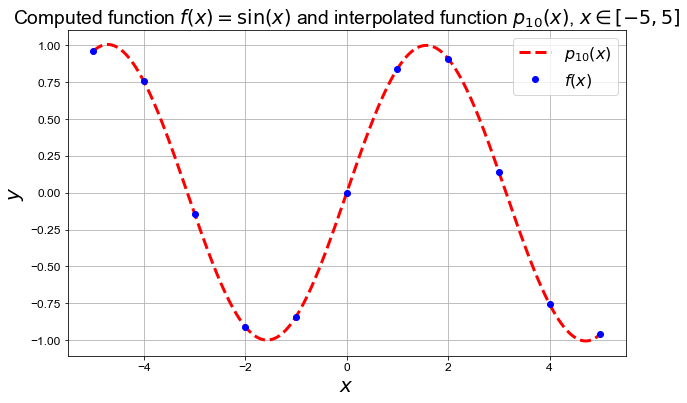

In [111]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['y_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['y_real10']
for i in range(len(y_real)):
    pylab.plot(data['n_10'][i], y_real[i], 'bo')

pylab.title('Computed function $f(x) = \sin(x)$ and interpolated function $p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

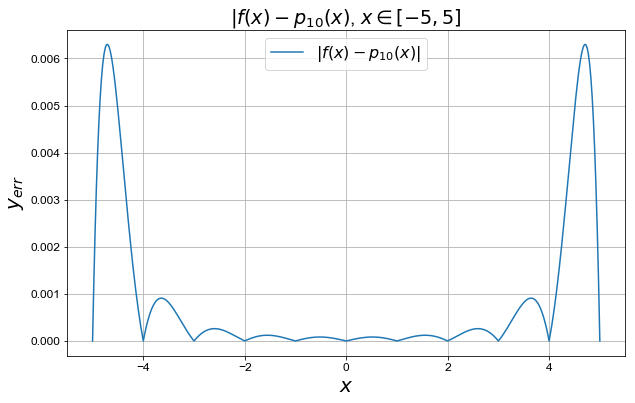

In [112]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['y_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

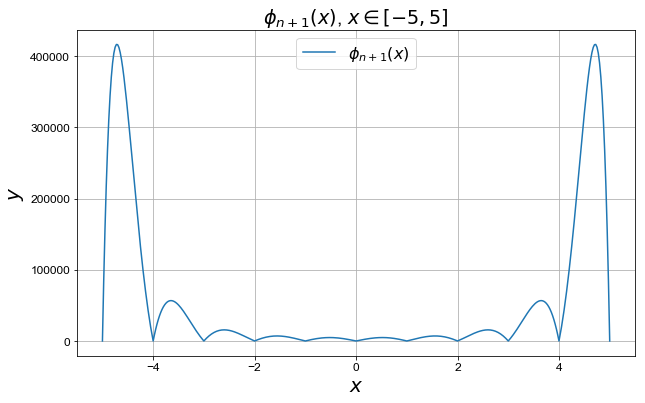

In [113]:
# plot in your report the graphs of phi_{n+1}(x) for
# the (n + 1) = 11 equally distributed nodes

pylab.plot(data['x_10'], data['omega10'])

pylab.title('$\phi_{n+1}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$\phi_{n+1}(x)$',))

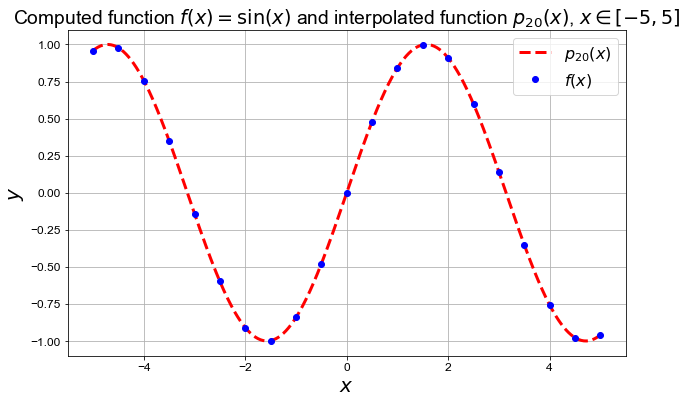

In [114]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 20

pylab.plot(data['x_20'], data['y_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['y_real20']
for i in range(len(y_real)):
    pylab.plot(data['n_20'][i], y_real[i], 'bo')

pylab.title('Computed function $f(x) = \sin(x)$ and interpolated function $p_{20}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

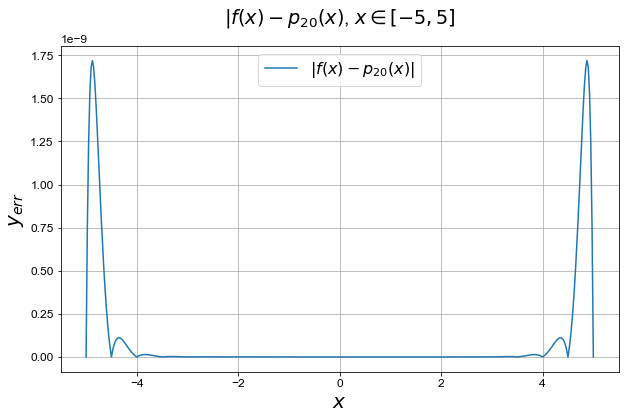

In [115]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['y_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

The graphs of $p_{10}(x)$ and $p_{20}(x)$ show that the interpolating polynomial fits the data well, the difference being that $p_{20}(x)$ does so with significantly less error. The error for $p_{10}(x)$ is on the order of $1.0\mathrm{e}-3$, while the error for $p_{20}(x)$ is two orders of magnitude smaller. This is further evidence that indicates that more data points leads to better approximations.

In comparing the error $|f(x) - p_{10}(x)|$ and $\phi_{n+1}(x)$ for $n = 11$, it is evident that the two are fundamentally linked. The graphs are seemingly identical; the only difference seems to be the order of magnitude ($1.0\mathrm{e}-3$ for $|f(x) - p_{10}(x)|$ and $1.0\mathrm{e}+5$ for $\phi_{n+1}(x)$).



#### Part B

In [119]:
names = [ 'runge_uniform_real10', 'runge_uniform_comp10', 'runge_uniform_err10', \
          'runge_uniform_real20', 'runge_uniform_comp20', 'runge_uniform_err20', \
          'runge_uniform_omega10' ]
data = {name: loadtxt('../res/part2/runge_uniform/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

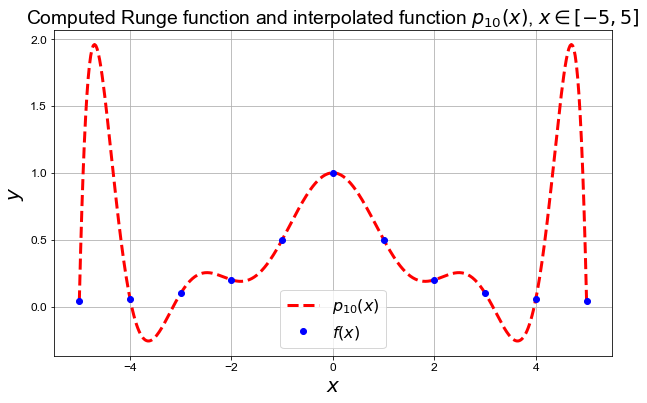

In [120]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_uniform_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_uniform_real10']
for i in range(len(y_real)):
    pylab.plot(data['n_10'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

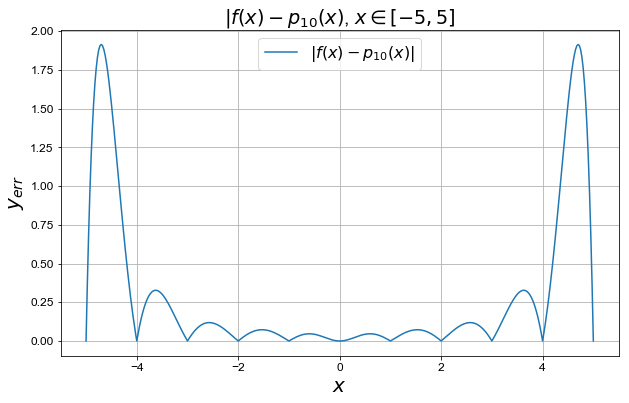

In [121]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['runge_uniform_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

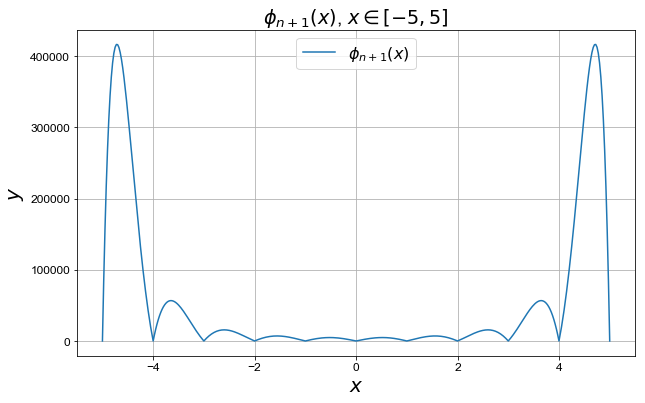

In [122]:
# plot in your report the graphs of phi_{n+1}(x) for
# the (n + 1) = 11 equally distributed nodes

pylab.plot(data['x_10'], data['runge_uniform_omega10'])

pylab.title('$\phi_{n+1}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$\phi_{n+1}(x)$',))

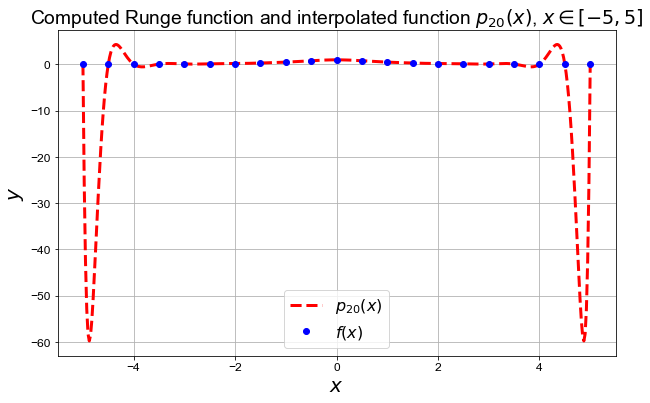

In [267]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 20

pylab.plot(data['x_20'], data['runge_uniform_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_uniform_real20']
for i in range(len(y_real)):
    pylab.plot(data['n_20'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{20}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

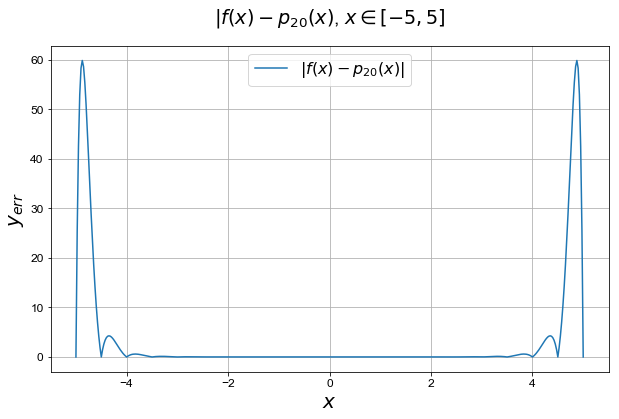

In [268]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['runge_uniform_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

When changing to the Runge function using the same underlying linear space, it seems that while both interpolating polynomials fit the data, more data points are not helpful in approximating the function. In fact, there is are wild jumps in the graph compared to the true graph of the main function. In terms of error, the order of magnitude for $p_{10}(x)$ is $1.0\mathrm{e}+1$ compared to $1.0\mathrm{e}+2$ for $p_{20}(x)$. This is especially evident in the main graphs, where towards the ends of the evaluating interval the polynomial curve peaks to a certain extent for $p_{10}(x)$ but dips so extremely for $p_{20}(x)$ that it's difficult to see the rest of the graph.

Once again, in comparing the error $|f(x) - p_{10}(x)|$ and $\phi_{n+1}(x)$ for $n = 11$, it is evident that the two are fundamentally linked. Again, the only difference seems to be the order of magnitude ($1.0\mathrm{e}+1$ for $|f(x) - p_{10}(x)|$ and $1.0\mathrm{e}+5$ for $\phi_{n+1}(x)$).

#### Part C

In [150]:
names = [ 'runge_Chebyshev_real10', 'runge_Chebyshev_comp10', 'runge_Chebyshev_err10', \
          'runge_Chebyshev_real20', 'runge_Chebyshev_comp20', 'runge_Chebyshev_err20', \
          'runge_Chebyshev_nodes10', 'runge_Chebyshev_nodes20', 'runge_Chebyshev_omega10' ]
data = {name: loadtxt('../res/part2/runge_chebyshev/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

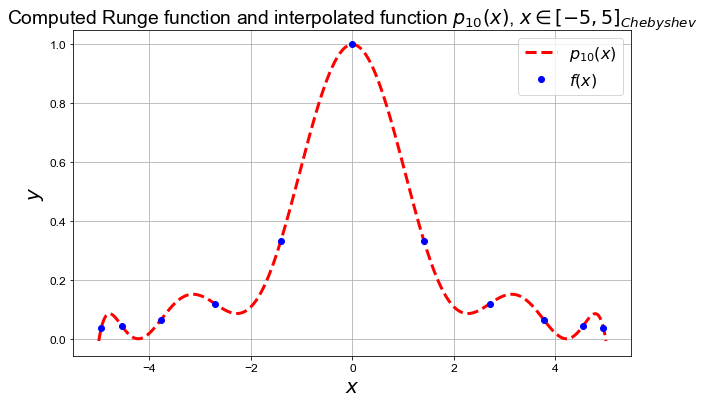

In [151]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_Chebyshev_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_Chebyshev_real10']
for i in range(len(y_real)):
    pylab.plot(data['runge_Chebyshev_nodes10'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{10}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

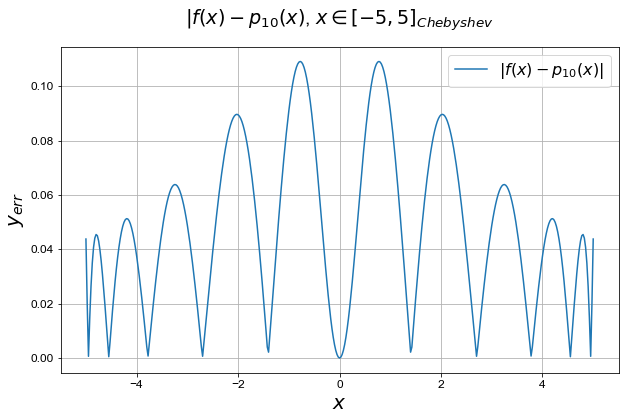

In [152]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['runge_Chebyshev_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]_{Chebyshev}$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

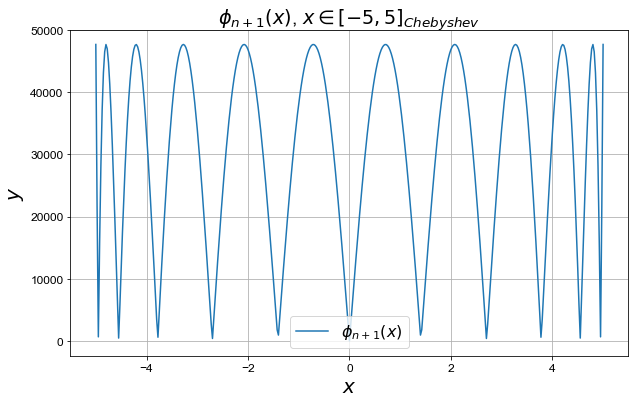

In [153]:
# plot in your report the graphs of phi_{n+1}(x) for
# the 11 Chebyshev nodes

pylab.plot(data['x_10'], data['runge_Chebyshev_omega10'])

pylab.title('$\phi_{n+1}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$\phi_{n+1}(x)$',))

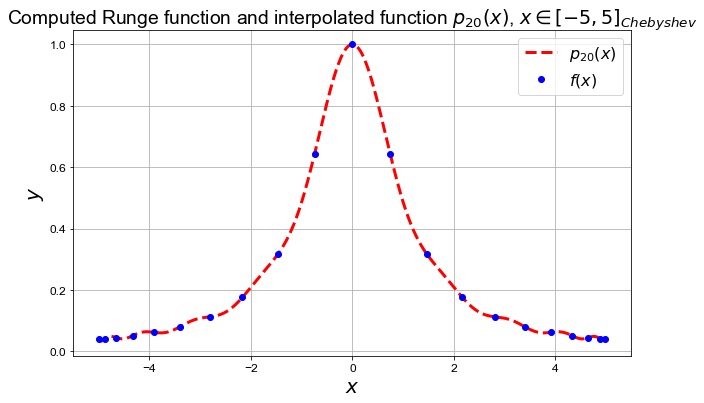

In [154]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_Chebyshev_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_Chebyshev_real20']
for i in range(len(y_real)):
    pylab.plot(data['runge_Chebyshev_nodes20'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{20}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

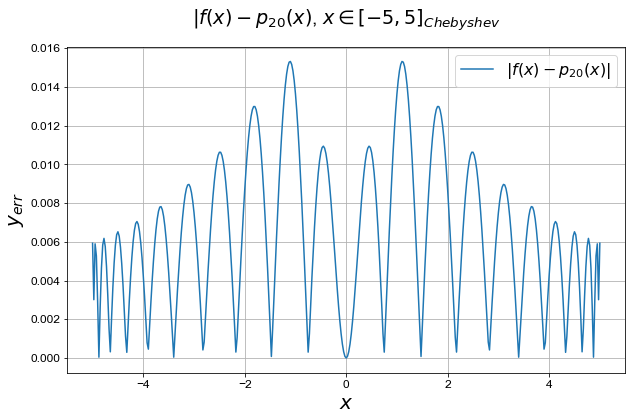

In [155]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['runge_Chebyshev_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]_{Chebyshev}$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

Instad of changing the underlying function, this time we changed the underlying linear space, from n+1 equally spaced nodes to n+1 Chebyshev nodes. For this particular function, the Chebyshev nodes seem to allow for the construction of a better interpolating polynomial in terms of matching the base function. In this case, the error for both sets of nodes $n$ is on the same order of magnitude $1.0\mathrm{e}+-3$, which would seem to indicate once more that increasing the number of data points is not as helpful in approximating the function.

Contrary to the previous two sections, the graphs of the error $|f(x) - p_{10}(x)|$ and $\phi_{n+1}(x)$ for $n = 11$ Chebyshev nodes do not seem to be linked. While the amplitude of the error decreases as $x$ approaches either end of the interval, the amplitude of $\phi_{n+1}(x)$ does not change at all over the interval. Again, the order of magnitude is significantly different between the two: ($1.0\mathrm{e}-2$ for $|f(x) - p_{10}(x)|$ and $1.0\mathrm{e}+4$ for $\phi_{n+1}(x)$).

## Part 3 - Application

Part 3 covers a practical application of interpolation, in this case interpolating a polynomial for a given set of decades and average global temperatures. Then, we attempt to use the same polynomial to predict the average global temperatures for other decades (extrapolation).

### Background

Given a set of decades and average global temperatures (see table below), we can predict the temperatures for a given year within the interval of those decades by constructing an interpolating polynomial. Since in the previous sections we implemented two separate methods for constructing interpolating polynomials, we can pick either one for use in this exercise. In this case, we use the Lagrange method.

In [129]:
from IPython.display import (HTML, display)

decades = ['1880-1890', '1890-1900', '1900-1910', '1910-1920', \
           '1920-1930', '1930-1940', '1940-1950', '1950-1960', \
           '1960-1970', '1970-1980', '1980-1990', '1990-2000']
temps = ['56.70', '56.72', '56.87', '56.89', \
         '57.01', '57.21', '57.28', '57.18', \
         '57.12', '57.22', '57.65', '57.89']

table = [ decades, temps ]

table[0] = np.hstack(('Decade', table[0]))
table[1] = np.hstack(('Temperature (°F)', table[1]))

table = zip(*table)

display(HTML('<h4>Average Global Temperatures for the Decades 1880-2000<h4>'))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
        )
 ))

Decade,Temperature (°F)
1880-1890,56.70
1890-1900,56.72
1900-1910,56.87
1910-1920,56.89
1920-1930,57.01
1930-1940,57.21
1940-1950,57.28
1950-1960,57.18
1960-1970,57.12
1970-1980,57.22


### Implementation

To construct the interpolating polynomial, we used much of the same steps as in Part 2.

In a file `application.cpp`, we create a `PH::Vector` of the middle years of the decade (e.g. for the decade 1880-1890, the value is 1885), mapped to a `PH::Vector` of the average global temperature for that decade. Then, we create a `PH::Vector` containing 200 equally spaced data points between $[1885,1995]$. Using this linear space and the `lagrange` function, we generated data to plot the interpolating polynomial. See the results below.

### Analysis

#### Part A

In [246]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [247]:
names = [ 'years', 'temps', 'comp', ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}
data['x'] = linspace(1885,1995,200) 

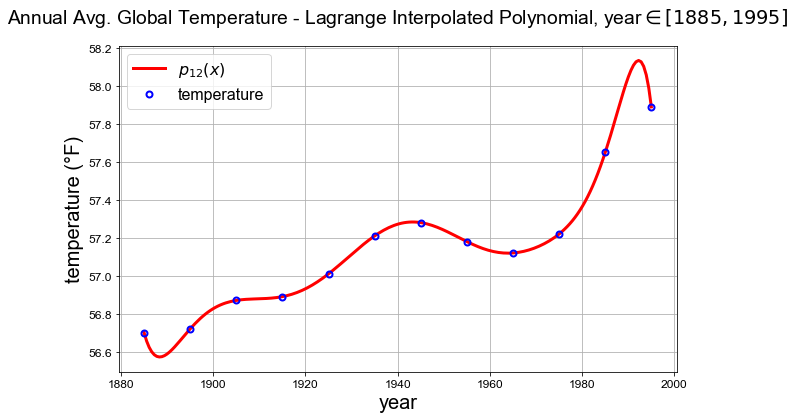

In [249]:
# Plot the interpolating polynomial through this data using 200 points
# in the interval [1885, 1995] with a solid line. On the same plot, overlay
# the data values as open circles.

pylab.plot(data['x'], data['comp'], color='r', linewidth=3)

y_real = data['temps']
for i in range(len(y_real)):
    pylab.plot(data['years'][i], y_real[i], 'bo', markeredgewidth=2, markerfacecolor='none')

pylab.title('Annual Avg. Global Temperature - Lagrange Interpolated Polynomial, year$\in [1885, 1995]$', y=1.05)
pylab.xlabel('year')
pylab.ylabel('temperature (°F)')
pylab.grid()

pylab.legend(('$p_{12}(x)$',
              'temperature'))

As the graph shows, the polynomial fits the given data points very well.

#### Part B

In this section, we were asked to predict the average global temperature for the years:

* 1903 (first flight by the Wright brothers)
* 1941 (attack on Pearl Harbor)
* 1963 (JFK assassination)
* 1969 (moon landing)
* 1976 (first Apple computer)
* 1989 (fall of the Berlin wall)
* 1999 (Columbine shootings)
* 2009 (discovery of water on moon)
* 2015

To do this, we simply plugged these values into the same Lagrangian interpolating polynomial function as the previous section.

In [124]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [125]:
names = [ 'predict_years', 'predict_temps' ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}

data['predict_years'] = list(map(int, data['predict_years']))
data['predict_temps'] = [f"{x:.2f}" for x in data['predict_temps']]
data['actual_temps'] = [56.71, 57.40, 57.25, 57.20, 56.79, 57.69, 57.97, 58.50, 58.62]
data['temp_deltas'] = [float(x) - y for x,y in zip(data['predict_temps'], data['actual_temps'])]
data['temp_deltas'] = [f"{x:.2f}" for x in data['temp_deltas']]

In [126]:
from IPython.display import (HTML, display)

table = [ data['predict_years'], data['predict_temps'] ]

table[0] = np.hstack(('Year', table[0]))
table[1] = np.hstack(('Predicted Temperature (ºF)', table[1]))

table = zip(*table)

display(HTML('<h5>Predicted Temperatures for Given Years using Lagrangian interpolation<h5>'))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
        )
 ))

Year,Predicted Temperature (ºF)
1903,56.86
1941,57.28
1963,57.12
1969,57.14
1976,57.24
1989,57.97
1999,55.70
2009,9.58
2015,-113.21


Based on the output of this function, it would seem that the interpolating polynomial does a good job of predicting temperatures for years within the interval $[1885,1995]$. However, as soon as the predicting year leaves the interval the temperature predictions very quickly become extreme and almost certainly incorrect.

#### Part C

In [127]:
from IPython.display import (HTML, display)

table = [ data['predict_years'], data['predict_temps'], data['actual_temps'], data['temp_deltas'] ]

table[0] = np.hstack(('Year', table[0]))
table[1] = np.hstack(('Predicted Temperature (ºF)', table[1]))
table[2] = np.hstack(('Actual Temperature (ºF)', table[2]))
table[3] = np.hstack(('$\Delta$ Temperature', table[3]))

table = zip(*table)

display(HTML('<h5>Predicted Temperatures for Given Years using Lagrangian interpolation<h5>'))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
        )
 ))

Year,Predicted Temperature (ºF),Actual Temperature (ºF),$\Delta$ Temperature
1903,56.86,56.71,0.15
1941,57.28,57.4,-0.12
1963,57.12,57.25,-0.13
1969,57.14,57.2,-0.06
1976,57.24,56.79,0.45
1989,57.97,57.69,0.28
1999,55.70,57.97,-2.27
2009,9.58,58.5,-48.92
2015,-113.21,58.62,-171.83


The table above compares the predicted temperature with the actual recorded temperature, in addition to the difference ($\Delta$) between prediction and reality. As the $\Delta\ $Temperature column shows, the interpolating polynomial does a good job of predicting the temperatures for years within the interval, where the prediction is at most <0.5 ºF off. However, for those years where we are extrapolating, the differences increase wildly, going as far as to be as much as approximately 172 ºF less than the actual recorded temperature.

#### Part D

In this section, we extend the interval over which we generate the data from the interpolating polynomial and then plot the resulting data.

In [134]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [135]:
names = [ 'years', 'temps', 'comp_extended', 'predict_years', 'predict_temps' ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}
data['x'] = linspace(1885,2015,200)

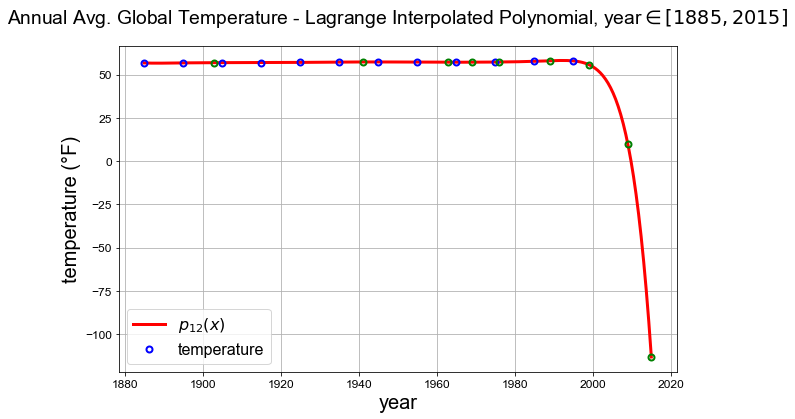

In [136]:
# Plot the interpolating polynomial through this data using 200 points
# in the interval [1885, 2015] with a solid line. On the same plot, overlay
# the data values as open circles.

pylab.plot(data['x'], data['comp_extended'], color='r', linewidth=3)

y_real = data['temps']
for i in range(len(y_real)):
    pylab.plot(data['years'][i], y_real[i], 'bo', markeredgewidth=2, markerfacecolor='none')

y_predict = data['predict_temps']
for i in range(len(y_predict)):
    pylab.plot(data['predict_years'][i], y_predict[i], 'go', markeredgewidth=2, markerfacecolor='none')
    
pylab.title('Annual Avg. Global Temperature - Lagrange Interpolated Polynomial, year$\in [1885, 2015]$', y=1.05)
pylab.xlabel('year')
pylab.ylabel('temperature (°F)')
pylab.grid()

pylab.legend(('$p_{12}(x)$',
              'temperature'))

In addition to plotting the actual years and temperatures, the predicted temperatures have been plotted as well using green circles. Once again, the interpolating polynomial seems to do a good job of predicting the temperatures for years within the original interval, but for extrapolating years the error diverges quickly. Since the interval extends so far past years with actual data, the error increases to an extreme degree, in this case so far that it's difficult to see the shape of the polynomial about the actual data points.